In [51]:
!pip install --upgrade gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import numpy as np
import random
import os
import string
import nltk
import gensim
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%tensorflow_version 2.x
import tensorflow
# import tensorflow.keras as keras

from google.colab import drive

from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Reshape, Bidirectional, Flatten, Input, GlobalAveragePooling1D
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTEN
from collections import Counter

nltk.download('punkt')

# tensorflow.device('/device:GPU:0')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
RANDOM_SEED = 12
MAX_FEATURES = 200000
EMBEDDINGS_DIM = 100
MAX_DOC_LEN = 1000

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'

from google.colab import drive
drive.mount('/content/drive')

ESPECTROS = ('esquerda', 'centro', 'direita')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
MIN_TAM = 250
MAX_TAM = 1000
LEGISLATURA = 56

df_treino = pd.read_json(ROOTDIR + f'data/treino_discurso_{MIN_TAM}_{MAX_TAM}_{LEGISLATURA}.json')
df_teste = pd.read_json(ROOTDIR + f'data/teste_discurso_{MIN_TAM}_{MAX_TAM}_{LEGISLATURA}.json')

In [55]:
Counter(df_treino.espectro)

Counter({'centro': 2189, 'direita': 4277, 'esquerda': 8775})

In [56]:
Counter(df_teste.espectro)

Counter({'direita': 1070, 'centro': 547, 'esquerda': 2194})

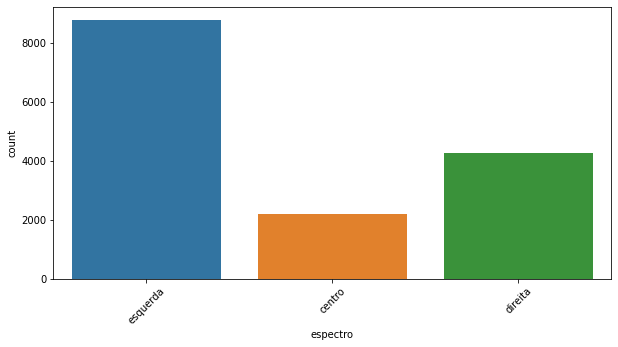

In [57]:
fig = plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro', data = df_treino, order=ESPECTROS)
plt.show()

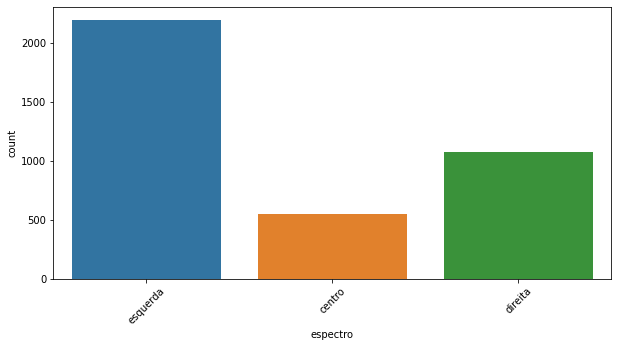

In [58]:
fig = plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro' , data = df_teste, order=ESPECTROS)
plt.show()

In [59]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(pd.concat((df_treino, df_teste))['tokens'])

In [60]:
labeler = LabelEncoder()
labeler.fit(df_treino['espectro'])

LabelEncoder()

In [61]:
X_treino = df_treino['tokens']
X_teste = df_teste['tokens']

X_treino = tokenizer.texts_to_sequences(X_treino)
X_treino = sequence.pad_sequences(X_treino, maxlen=MAX_DOC_LEN)

X_teste = tokenizer.texts_to_sequences(X_teste)
X_teste = sequence.pad_sequences(X_teste, maxlen=MAX_DOC_LEN)

In [62]:
Y_treino = df_treino['espectro']
Y_teste = df_teste['espectro']

In [63]:
# smote = SMOTEN(random_state=RANDOM_SEED, sampling_strategy='auto')
# X_treino_, Y_treino_ = smote.fit_resample(X_treino, Y_treino)
X_treino_, Y_treino_ = X_treino, Y_treino

In [64]:
# plt.figure(figsize=(10, 5))
# plt.xticks(rotation=45)
# sns.countplot(x=Y_treino_, order=ESPECTROS)
# plt.show()

In [65]:
# rus = RandomUnderSampler(random_state=RANDOM_SEED, sampling_strategy='auto')

# X_treino_, Y_treino_ = rus.fit_resample(X_treino_, Y_treino_)

In [66]:
# plt.figure(figsize=(10, 5))
# plt.xticks(rotation=45)
# sns.countplot(x=Y_treino_, order=ESPECTROS)
# plt.show()

In [67]:
Y_treino_ = to_categorical(labeler.transform(Y_treino_), len(ESPECTROS), dtype='float32')
Y_teste = to_categorical(labeler.transform(Y_teste), len(ESPECTROS), dtype='float32')

In [68]:
w2v = Word2Vec.load(ROOTDIR + f'data/camares.{EMBEDDINGS_DIM}.w2v')

MAX_FEATURES = len(tokenizer.index_word)

embeddings_mean, embeddings_std = w2v.wv.vectors.mean(), w2v.wv.vectors.std()

embeddings_matrix = np.random.normal(embeddings_mean, embeddings_std, size=(MAX_FEATURES+1, EMBEDDINGS_DIM))

for word, i in tokenizer.word_index.items():
    if i > MAX_FEATURES: continue
    try:
      embeddings_matrix[i] = w2v.wv[word]
    except KeyError:
      pass

In [69]:
BATCH_SIZE = 200
EPOCHS = 250
PATIENCE_LR = 25
PATIENCE_ES = 50
FACTOR = 0.25
MIN_LR = 0.00000001
# PLATEAU_MONITOR = 'val_loss'
PLATEAU_MONITOR = 'val_categorical_crossentropy'
# PLATEAU_MONITOR = 'val_categorical_accuracy'
LSTM_LAYER1_SIZE = EMBEDDINGS_DIM
LSTM_LAYER2_SIZE = EMBEDDINGS_DIM
LAYER1_DROPOUT_RATE = 0.1
LAYER2_DROPOUT_RATE = 0.25
RECURRENT_DROPOUT_RATE = 0.2
DENSE_LAYER1_SIZE = EMBEDDINGS_DIM
DENSE_LAYER1_DROPOUT_RATE = 0.5
DENSE_LAYER2_SIZE = EMBEDDINGS_DIM
DENSE_LAYER2_DROPOUT_RATE = 0.5
DENSE_LAYER1_FUNCTION = 'tanh'
DENSE_LAYER2_FUNCTION = 'tanh'
OUTPUT_LAYER_SIZE = len(ESPECTROS)
OUTPUT_LAYER_FUNCTION = 'softmax'
LEARNING_RATE = 0.0001
OPTIMIZER = tensorflow.keras.optimizers.Adam
# OPTIMIZER = tensorflow.keras.optimizers.Nadam
LOSS_FUNCTION = 'categorical_crossentropy'
# LOSS_FUNCTION = 'poisson'
METRIC_FUNCTIONS = ['categorical_accuracy', 'categorical_crossentropy']
VALIDATION_SPLIT_RATE = 0.2


#  Init model
model = Sequential()

# INPUT
# model.add(Embedding(MAX_FEATURES, output_dim = EMBEDDINGS_DIM, weights = [embeddings_matrix], input_length = MAX_DOC_LEN, trainable = True))
model.add(Embedding(MAX_FEATURES+1, output_dim = EMBEDDINGS_DIM, weights = [embeddings_matrix], input_length = MAX_DOC_LEN, trainable = True, mask_zero=True))

# LSTM 1
model.add(Bidirectional(LSTM(LSTM_LAYER1_SIZE, return_sequences = True,  dropout = LAYER1_DROPOUT_RATE)))
# model.add(Bidirectional(LSTM(LSTM_LAYER1_SIZE, return_sequences = True)))

# LSTM 2
model.add(Bidirectional(LSTM(LSTM_LAYER2_SIZE, dropout = LAYER2_DROPOUT_RATE, recurrent_dropout = RECURRENT_DROPOUT_RATE)))
# model.add(Bidirectional(LSTM(LSTM_LAYER2_SIZE)))

# Dense 1
model.add(Dense(units = DENSE_LAYER1_SIZE, activation = DENSE_LAYER1_FUNCTION))
model.add(Dropout(DENSE_LAYER1_DROPOUT_RATE))

# Dense 2
model.add(Dense(DENSE_LAYER2_SIZE))

# Output
model.add(Dense(units = OUTPUT_LAYER_SIZE, activation = OUTPUT_LAYER_FUNCTION))

# Compile
model.compile(optimizer = OPTIMIZER(learning_rate = LEARNING_RATE), loss = LOSS_FUNCTION, metrics = METRIC_FUNCTIONS)

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         7299700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 1000, 200)        160800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)              

In [71]:
callbacks = [
  ReduceLROnPlateau(monitor = PLATEAU_MONITOR, patience = PATIENCE_LR, verbose = 2, factor = FACTOR, min_lr = MIN_LR),
  EarlyStopping(patience = PATIENCE_ES, verbose = True)      
]

if not os.path.isfile(ROOTDIR + f'data/classificador_discurso_espectro.dat'):

  history = model.fit(
      X_treino_, Y_treino_, 
      batch_size = BATCH_SIZE, 
      validation_split = VALIDATION_SPLIT_RATE, 
      epochs = EPOCHS, 
      callbacks = callbacks,
  )

  with open(ROOTDIR + f'data/classificador_discurso_espectro.dat', 'wb') as fp:
    pickle.dump(model, fp)

  df_history = pd.DataFrame(history.history)
  df_history.to_json(ROOTDIR + f'data/history_classificador_discurso_espectro.json')

else:

  with open(ROOTDIR + f'data/classificador_discurso_espectro.dat', 'rb') as fp:
    model = pickle.load(fp)

  df_history = pd.read_json(ROOTDIR + f'data/history_classificador_discurso_espectro.json')

In [ ]:
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

ax = df_history[['val_categorical_accuracy', 'categorical_accuracy']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

print("Acuracia de treinamento: {:.2f} %".format(model.evaluate(X_treino_, Y_treino_)[1]*100))
print("Acuracia de teste: {:.2f} %".format(model.evaluate(X_teste, Y_teste)[1]*100))

477/477 [==============================] - 231s 478ms/step - loss: 0.2391 - categorical_accuracy: 0.9402 - categorical_crossentropy: 0.2391
Acuracia de treinamento: 94.02 %
109/120 [==========================>...] - ETA: 5s - loss: 0.9657 - categorical_accuracy: 0.7967 - categorical_crossentropy: 0.9657

In [ ]:
previsto = labeler.inverse_transform(np.argmax(model.predict(X_teste[0:]), axis=1))

In [ ]:
real = labeler.inverse_transform(np.argmax(Y_teste[0:], axis=1))

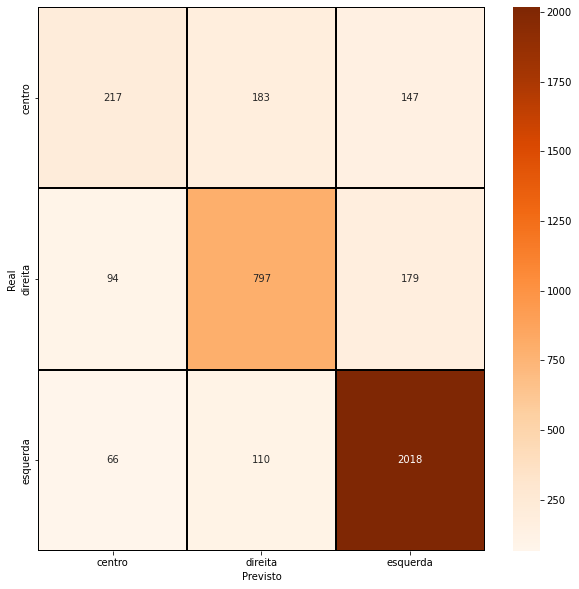

In [ ]:
cm = confusion_matrix(real, previsto)
cm = pd.DataFrame(cm, index = labeler.classes_, columns = labeler.classes_)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap = "Oranges", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labeler.classes_, yticklabels = labeler.classes_)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()